### mina training colab notebook

first we git clone and setup the latest code for training the model

In [ ]:
%cd /content/
!rm -rf mina model
!git clone https://github.com/fishcareyolo/fishcareyolo mina
!mv mina/model .
!rm -rf mina
%cd model/

now, we are in the model folder for the rest of this notebook

we use uv to create the venv and install all the python packages

In [ ]:
!uv sync

now we load the ` ROBOFLOW_API_KEY ` from the secrets tab in this colab

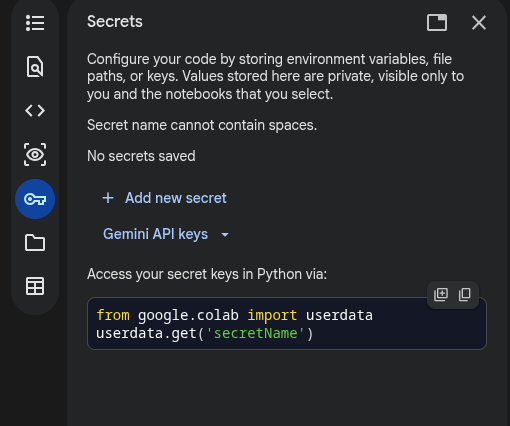

DO NOT RUN THIS WITHOUT SETTING THE SECRET TO A VALID API KEY

In [ ]:
from google.colab import userdata

ROBOFLOW_API_KEY = userdata.get("ROBOFLOW_API_KEY")

!export ROBOFLOW_API_KEY="{ROBOFLOW_API_KEY}" && uv run mina-download

training

now we train the model using the best hyperparameters found from tuning above.

YOLOv8 automatically loads the tuned hyperparameters from runs/tune/best_hyperparameters.yaml

In [ ]:
print(
    "training with tuned hyperparameters from runs/detect/tune/best_hyperparameters.yaml"
)

# Train with tuned hyperparameters using --hyp flag
!uv run mina-train --epochs 100 --batch 16 --hyp runs/detect/tune/best_hyperparameters.yaml

hyperparameter tuning

this step finds the best learning rate, momentum, batch size, etc for the dataset.

cost: tuning takes about 300 gpu hours (300 iterations x 30 epochs each). this is expensive and slow.

what it does: ray tune tests 300 different hyperparameter combinations to find the best values for training.

In [ ]:
%env MPLBACKEND=Agg # Anti-Grain Geometry https://github.com/ghaerr/agg-2.6

In [ ]:
print("starting hyperparameter tuning...")
print("this will take about 300 gpu hours (several days)")
print("testing 300 combinations x 30 epochs each")

# run tuning with 300 iterations (ray tune default)
# each iteration trains for 30 epochs (sufficient for evaluation)
!uv run mina-tune --iterations 300 --epochs 30 --optimizer AdamW

print("tuning complete! best hyperparameters saved to:")
print("   runs/tune/best_hyperparameters.yaml")

we trained the model, okay

but, we have no idea how it performs when it is given an image, which it has never seen before

so, we use our test data to evaluate model performance

In [ ]:
!uv run mina-evaluate --weights runs/detect/fish_disease/weights/best.pt

model is done, we export it to a tflite file for mobile inference

In [ ]:
!uv run mina-export --weights runs/detect/fish_disease/weights/best.pt

finally, let's test if the model works on inference

In [ ]:
!uv run mina-infer --dir data/images/val